<a href="https://colab.research.google.com/github/Loomer/2022-itc303-team08/blob/mach-learn-dev-cezanne/caFeasibilityTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assembling Datasets and Preprocessing**

This script demonstrates procurement of a dataset and preparing each image within for the convolutional layers.


First, we clone the repo to import the images:

In [ ]:
!git clone -b mach-learn-dev-cezanne  https://github.com/Loomer/2022-itc303-team08.git

Cloning into '2022-itc303-team08'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 310 (delta 9), reused 78 (delta 7), pack-reused 226
Receiving objects: 100% (310/310), 110.40 MiB | 25.69 MiB/s, done.
Resolving deltas: 100% (25/25), done.


Now we assemble images into arrays

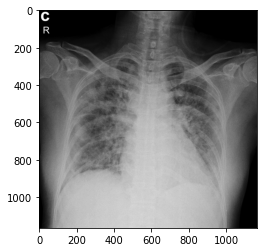

In [ ]:
import numpy as np # to assemble images in a splitable array
import matplotlib.pyplot as plt # To display curretn status of images
import os # for assembling directories
import cv2 # image preprocessing
from tqdm import tqdm # progress bar for convenience

DATADIR = "/content/2022-itc303-team08/images/ctrain" # Set data directory constant

CATEGORIES = ["NORMAL", "COVID"] # array of categories and directory names

for category in CATEGORIES:  # Iterate through folders
    
    path = os.path.join(DATADIR,category) # create path to NORMAL and COVID
    
    for img in os.listdir(path):  # iterate over each images
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array and change it to grayscale

#print(type(img_array))
plt.imshow(img_array, cmap='gray')  # graph the last image in pyplot
plt.show()  # display image


The images however come in various sizes so it is neccessary to resize the images to uniform dimensions. This is known as normalising data.

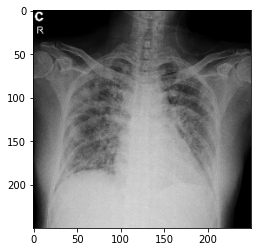

In [ ]:
IMG_SIZE = 250 # image dimensions contant

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # resizing images into 250 * 250

plt.imshow(new_array, cmap='gray')
plt.show()

The images are now the proper size.

For ease of use we now collapse the previous steps into a function.

In [ ]:
training_data = []

def create_training_data():
    for category in CATEGORIES: 

        path = os.path.join(DATADIR,category)  # create path to NOMRAL and COVID
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=NORMAL 1=COVID
        
        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except OSError as e:
                print("Image is most likely corrupt.", e, os.path.join(path,img))
            except Exception as e:
                print("An error has occured.", e, os.path.join(path,img))

create_training_data() # call method


100%|██████████| 100/100 [00:02<00:00, 49.65it/s]


The training data is arranged into an array however before convolving the training needs to be shuffled.

In [ ]:
import random

random.shuffle(training_data)

In [ ]:
for sample in training_data[:10]: # checking shuffling
    print(str(sample[1]), CATEGORIES[sample[1]])

0 NORMAL
0 NORMAL
1 COVID
1 COVID
0 NORMAL
0 NORMAL
1 COVID
0 NORMAL
0 NORMAL
0 NORMAL


In [ ]:
# Initilaising lists
X = [] # feature set 
y = [] # labels

In [ ]:
# Enter in feature and labels for training_data into lists
for features,label in training_data: 
    X.append(features)
    y.append(label)


Lists however cannot be enter the nerual network (the features at least). Therefore, the features are transferred into numpy array and needs to be reshaped.

In [ ]:
#.reshape(number_of_features, dimensions, colour/grayscale)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # -1 = variable number of features
y = np.array(y)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images horizontally
        vertical_flip=False)  # don't randomly flip images vertically

datagen.fit(X)

Instead of the creating the model again and again, we can store it using pickle. This will save the numpy arrays as files for quick access

In [ ]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()



# **Feeding dataset into Convolutional Neural Network**

In [ ]:
import pickle

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

model = Sequential()

model.add(Conv2D(32, kernel_size =(5, 5), activation = 'relu',  input_shape=X.shape[1:]))
model.add(Conv2D(64, (5, 5), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5, 5), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())  # converts 3D feature maps to 1D feature vectors
model.add(Dense(64, activation ='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y, batch_size=50, epochs=6, validation_split=0.2)

Epoch 1/6
4/4 [==============================] - 119s 27s/step - loss: 1.5727 - accuracy: 0.5312 - val_loss: 0.6920 - val_accuracy: 0.5500
Epoch 2/6
4/4 [==============================] - 116s 27s/step - loss: 0.6881 - accuracy: 0.5063 - val_loss: 0.6952 - val_accuracy: 0.4500
Epoch 3/6
4/4 [==============================] - 115s 27s/step - loss: 0.6954 - accuracy: 0.5375 - val_loss: 0.6917 - val_accuracy: 0.4500
Epoch 4/6
4/4 [==============================] - 115s 27s/step - loss: 0.6800 - accuracy: 0.4750 - val_loss: 0.6618 - val_accuracy: 0.6750
Epoch 5/6
4/4 [==============================] - 115s 27s/step - loss: 0.6503 - accuracy: 0.6125 - val_loss: 0.5799 - val_accuracy: 0.8000
Epoch 6/6
4/4 [==============================] - 115s 27s/step - loss: 0.4977 - accuracy: 0.7750 - val_loss: 0.3369 - val_accuracy: 0.9750


In [ ]:
model.save("cnn_model")

INFO:tensorflow:Assets written to: cnn_model/assets


In [ ]:
CATEGORIES = ["Healthy Lung", "Has COVID-19 pneumonia"]  # will use this to convert prediction num to string value


def prepare(filepath):
    
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # read in the image, convert to grayscale
    newer_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize image to match model's expected sizing
    
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # return the image with shaping that tf requires

model = tf.keras.models.load_model("cnn_model")

prefix = "/content/2022-itc303-team08/images/ctest/NORMAL"

for filename in os.listdir(prefix):
    if filename.endswith("jpg") or filename.endswith("jpeg") or filename.endswith("png"): 
        print(filename)
        prediction = model.predict([prepare(prefix + "/" + filename)])
        print(prediction)



NORMAL2-IM-1423-0001.jpeg
[[1.]]
NORMAL2-IM-1422-0001.jpeg
[[1.]]
NORMAL2-IM-1419-0001.jpeg
[[1.]]
NORMAL2-IM-1412-0001.jpeg
[[1.]]
NORMAL2-IM-1406-0001.jpeg
[[1.]]
